# Libraries imports

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cross_validation
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score,RandomizedSearchCV
from sklearn.preprocessing import Imputer
from sklearn.linear_model import Ridge,Lasso,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,accuracy_score,roc_auc_score,auc,precision_recall_curve
from sklearn.cluster import KMeans
from sklearn import svm,tree
from sklearn.model_selection import StratifiedShuffleSplit, KFold
from sklearn.utils import shuffle
from datetime import datetime, date, timedelta
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from numpy.random import vonmises
from numpy import interp
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,MinMaxScaler
%matplotlib inline

# Import raw dataset

In [2]:
rawCardTable= pd.read_csv('data_for_student_case.csv')

# Preprocessing data
- Check % of fraudulent data
- Missing values treatment
    - check every column that has Nan
- Convert object types
- Convert simple_journal to binary variable


In [3]:
# first 5 rows
rawCardTable.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271


In [4]:
# check types of data and missing values
rawCardTable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290382 entries, 0 to 290381
Data columns (total 17 columns):
txid                            290382 non-null int64
bookingdate                     290382 non-null object
issuercountrycode               289889 non-null object
txvariantcode                   290382 non-null object
bin                             290242 non-null float64
amount                          290382 non-null float64
currencycode                    290382 non-null object
shoppercountrycode              289900 non-null object
shopperinteraction              290382 non-null object
simple_journal                  290382 non-null object
cardverificationcodesupplied    275665 non-null object
cvcresponsecode                 290382 non-null int64
creationdate                    290382 non-null object
accountcode                     290382 non-null object
mail_id                         290382 non-null object
ip_id                           290382 non-null object
card_id  

In [5]:
rawCardTable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290382 entries, 0 to 290381
Data columns (total 17 columns):
txid                            290382 non-null int64
bookingdate                     290382 non-null object
issuercountrycode               289889 non-null object
txvariantcode                   290382 non-null object
bin                             290242 non-null float64
amount                          290382 non-null float64
currencycode                    290382 non-null object
shoppercountrycode              289900 non-null object
shopperinteraction              290382 non-null object
simple_journal                  290382 non-null object
cardverificationcodesupplied    275665 non-null object
cvcresponsecode                 290382 non-null int64
creationdate                    290382 non-null object
accountcode                     290382 non-null object
mail_id                         290382 non-null object
ip_id                           290382 non-null object
card_id  

### Missing values treatment

In [6]:
rawCardTable['issuercountrycode'].fillna(-1)
rawCardTable['bin'].fillna(-1)
rawCardTable['shoppercountrycode'].fillna(-1)
rawCardTable['temp']=np.where(rawCardTable['cvcresponsecode']==1, True, False)
rawCardTable['cardverificationcodesupplied']= rawCardTable['cardverificationcodesupplied'].fillna(rawCardTable['temp'])
rawCardTable.drop('temp', axis=1)
rawCardTable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290382 entries, 0 to 290381
Data columns (total 18 columns):
txid                            290382 non-null int64
bookingdate                     290382 non-null object
issuercountrycode               289889 non-null object
txvariantcode                   290382 non-null object
bin                             290242 non-null float64
amount                          290382 non-null float64
currencycode                    290382 non-null object
shoppercountrycode              289900 non-null object
shopperinteraction              290382 non-null object
simple_journal                  290382 non-null object
cardverificationcodesupplied    290382 non-null bool
cvcresponsecode                 290382 non-null int64
creationdate                    290382 non-null object
accountcode                     290382 non-null object
mail_id                         290382 non-null object
ip_id                           290382 non-null object
card_id    

In [7]:
rawCardTable['bookingdate'] = pd.to_datetime(rawCardTable['bookingdate'])
rawCardTable['creationdate'] = pd.to_datetime(rawCardTable['creationdate'])
rawCardTable['onlydate'] = rawCardTable['creationdate'].dt.date
rawCardTable['time']= rawCardTable['creationdate'].dt.time

### Binary Label for target

In [8]:
def label (row):
    if row['simple_journal'] == 'Chargeback' :
        return 1
    if row['simple_journal'] == 'Refused' :
        return 2
    return 0

In [9]:
rawCardTable['target'] = rawCardTable.apply (lambda row: label (row),axis=1)
rawCardTable

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,...,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id,temp,onlydate,time,target
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,...,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798,False,2015-07-01,23:03:11,1
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,...,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595,False,2015-07-02,04:50:55,1
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,...,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142,False,2015-07-02,14:30:28,1
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,...,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744,False,2015-07-03,07:53:37,1
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,...,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271,False,2015-07-08,18:35:35,1
5,6,2015-11-09 14:26:25,MX,visaclassic,493161.0,79900.0,MXN,MX,Ecommerce,Chargeback,...,0,2015-07-08 23:04:26,MexicoAccount,email243511,ip112410,card159816,False,2015-07-08,23:04:26,1
6,7,2015-11-09 14:26:47,MX,visaclassic,477291.0,69900.0,MXN,MX,Ecommerce,Chargeback,...,0,2015-07-09 02:31:36,MexicoAccount,email137086,ip83481,card251249,False,2015-07-09,02:31:36,1
7,8,2015-11-23 16:34:29,MX,mccredit,520416.0,129900.0,MXN,MX,Ecommerce,Chargeback,...,0,2015-07-09 04:56:48,MexicoAccount,email295644,ip66704,card70297,False,2015-07-09,04:56:48,1
8,9,2015-12-08 19:58:35,MX,visaclassic,477291.0,129900.0,MXN,MX,Ecommerce,Chargeback,...,0,2015-07-09 22:55:40,MexicoAccount,email115605,ip68088,card39791,False,2015-07-09,22:55:40,1
9,10,2015-11-09 14:25:50,MX,mccredit,549138.0,99900.0,MXN,MX,Ecommerce,Chargeback,...,0,2015-07-11 09:44:14,MexicoAccount,email182966,ip113025,card160922,False,2015-07-11,09:44:14,1


In [10]:
#check the Percentage of fraudulent transactions
benignTrans = len(rawCardTable[rawCardTable["target"]==0]) # benign transactions are represented by 0
fraudTrans = len(rawCardTable[rawCardTable["target"]==1]) # fraud by 1
mightTrans = len(rawCardTable[rawCardTable["target"]==2])
percBenignTrans = benignTrans/(fraudTrans+benignTrans+mightTrans)
print("percentage of benign  transaction is",percBenignTrans*100)
percMightTrans = mightTrans/(fraudTrans+benignTrans+mightTrans)
print("percentage of refused transaction is",percMightTrans*100)
percFraudTrans = fraudTrans/(fraudTrans+benignTrans+mightTrans)
print("percentage of fraud transaction",percFraudTrans*100)

percentage of benign  transaction is 81.51021757546955
percentage of refused transaction is 18.37097340744261
percentage of fraud transaction 0.11880901708783602


# Convert categorical variables

In [11]:
# convert everything to the same currency
currency_dict = {'MXN': 0.01*0.05, 'SEK': 0.01*0.11, 'AUD': 0.01*0.67, 'GBP': 0.01*1.28, 'NZD': 0.01*0.61}
def convert(cur,amount):
    return (currency_dict[cur]*amount)

rawCardTable['euro'] = rawCardTable.apply(lambda row: convert(row['currencycode'],row['amount']),axis=1)

In [12]:
#cardTableProc = cardTable.rename(index=str, columns = {'txvariantcode': 'cardtype', 'bin': 'issuer_id', 'shopperinteraction': 'shoppingtype',
#                   'simple_journal': 'label', 'cardverificationcodesupplied': 'cvcsupply', 
#                  'cvcresponsecode': 'cvcresponse', 'accountcode': 'merchant_id'})

#cardTableProc
issuercountrycode_category = pd.Categorical.from_array(rawCardTable['issuercountrycode'])
cardtype_category = pd.Categorical.from_array(rawCardTable['txvariantcode'])
issuer_id_category = pd.Categorical.from_array(rawCardTable['bin'])
currencycode_category = pd.Categorical.from_array(rawCardTable['currencycode'])
shoppercountrycode_category = pd.Categorical.from_array(rawCardTable['shoppercountrycode'])
shoppingtype_category = pd.Categorical.from_array(rawCardTable['shopperinteraction'])
cvcsupply_category = pd.Categorical.from_array(rawCardTable['cardverificationcodesupplied'])
merchant_id_category = pd.Categorical.from_array(rawCardTable['accountcode'])
mail_id_category = pd.Categorical.from_array(rawCardTable['mail_id'])
ip_id_category = pd.Categorical.from_array(rawCardTable['ip_id'])
card_id_category = pd.Categorical.from_array(rawCardTable['card_id'])

issuercountrycode_dict = dict(set(zip(issuercountrycode_category, issuercountrycode_category.codes)))
cardtype_dict = dict(set(zip(cardtype_category, cardtype_category.codes)))
currencycode_dict = dict(set(zip(currencycode_category, currencycode_category.codes)))
shoppercountrycode_dict = dict(set(zip(shoppercountrycode_category, shoppercountrycode_category.codes)))
shoppingtype_dict = dict(set(zip(shoppingtype_category, shoppingtype_category.codes)))
cvcsupply_dict = dict(set(zip(cvcsupply_category, cvcsupply_category.codes)))
merchant_id_dict = dict(set(zip(merchant_id_category, merchant_id_category.codes)))
mail_id_dict = dict(set(zip(mail_id_category, mail_id_category.codes)))
ip_id_dict = dict(set(zip(ip_id_category, ip_id_category.codes)))
card_id_dict = dict(set(zip(card_id_category, card_id_category.codes)))



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Categorical.from_array is deprecated, use Categorical instead
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Categorical.from_array is deprecated, use Categorical instead
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Categorical.from_array is deprecated, use Categorical instead
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Categorical.from_array is deprecated, use Categorical instead
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Categorical.from_array is deprecated, use Categorical instead
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Categorical.from_array is deprecated, use Categorical instead
  # This is added back by InteractiveShellApp.init

In [13]:
catCardTable = rawCardTable

In [14]:
## definir que colunas da data para classificador
#toClassifyCardTable = ..
catCardTable['issuercountrycode'] = issuercountrycode_category.codes
catCardTable['txvariantcode'] = cardtype_category.codes
catCardTable['bin'] = currencycode_category.codes
catCardTable['shoppercountrycode'] = shoppercountrycode_category.codes
catCardTable['shopperinteraction'] = shoppingtype_category.codes
catCardTable['cardverificationcodesupplied'] = cvcsupply_category.codes
catCardTable['accountcode'] = merchant_id_category.codes
catCardTable['mail_id'] = mail_id_category.codes
catCardTable['ip_id'] = ip_id_category.codes
catCardTable['card_id'] = card_id_category.codes
catCardTable['label_int'], catCardTable['cvcresponse_int']= 0,0


catCardTable['cvcresponse_int'] = map(lambda x:3 if x > 2 else x+0, catCardTable['cardverificationcodesupplied'])
#0 = Unknown, 1=Match, 2=No Match, 3=Not checked
## remove all REFUSED transactions
catCardTable['bin'] = catCardTable['bin'].astype(int)
catCardTable['target'] = catCardTable['target'].astype(int)
catCardTable['euro'] = catCardTable['euro'].astype(float)
unFilteredCardTable = catCardTable 
catCardTable = catCardTable.ix[(catCardTable['target']==1) | (catCardTable['target']==0)]#237036 instances



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


# Without AggregatedFeatures

In [15]:
catCardTable.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 237036 entries, 0 to 290381
Data columns (total 24 columns):
txid                            237036 non-null int64
bookingdate                     237036 non-null datetime64[ns]
issuercountrycode               237036 non-null int16
txvariantcode                   237036 non-null int8
bin                             237036 non-null int64
amount                          237036 non-null float64
currencycode                    237036 non-null object
shoppercountrycode              237036 non-null int16
shopperinteraction              237036 non-null int8
simple_journal                  237036 non-null object
cardverificationcodesupplied    237036 non-null int8
cvcresponsecode                 237036 non-null int64
creationdate                    237036 non-null datetime64[ns]
accountcode                     237036 non-null int8
mail_id                         237036 non-null int32
ip_id                           237036 non-null int32
card_id

# Aggregated Features

In [16]:
#Aggregating features and everything with zeros

aggCols=['LastTransactionin2hrsr','SuspShopInt','SuspCardVerif','SuspCVCCode','IPChange','AmountChange']
aggregatedFeatures = pd.DataFrame(0, index=np.arange(0,catCardTable.shape[0]),columns=aggCols)
catCardTable.reset_index(drop=True, inplace=True)
aggregatedFeatures.reset_index(drop=True, inplace=True)
aggCardTable = pd.concat([catCardTable,aggregatedFeatures],axis=1)

aggCardTable

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,...,target,euro,label_int,cvcresponse_int,LastTransactionin2hrsr,SuspShopInt,SuspCardVerif,SuspCVCCode,IPChange,AmountChange
0,1,2015-11-09 14:26:51,92,3,2,64800.0,MXN,103,1,Chargeback,...,1,32.4000,0,<map object at 0x1a23747940>,0,0,0,0,0,0
1,2,2015-11-09 14:27:38,92,3,2,44900.0,MXN,103,1,Chargeback,...,1,22.4500,0,<map object at 0x1a23747940>,0,0,0,0,0,0
2,3,2015-11-23 16:34:16,92,3,2,149900.0,MXN,103,1,Chargeback,...,1,74.9500,0,<map object at 0x1a23747940>,0,0,0,0,0,0
3,4,2015-11-23 16:34:51,92,3,2,109900.0,MXN,103,1,Chargeback,...,1,54.9500,0,<map object at 0x1a23747940>,0,0,0,0,0,0
4,5,2015-11-09 14:26:08,92,7,2,89900.0,MXN,103,1,Chargeback,...,1,44.9500,0,<map object at 0x1a23747940>,0,0,0,0,0,0
5,6,2015-11-09 14:26:25,92,7,2,79900.0,MXN,103,1,Chargeback,...,1,39.9500,0,<map object at 0x1a23747940>,0,0,0,0,0,0
6,7,2015-11-09 14:26:47,92,7,2,69900.0,MXN,103,1,Chargeback,...,1,34.9500,0,<map object at 0x1a23747940>,0,0,0,0,0,0
7,8,2015-11-23 16:34:29,92,3,2,129900.0,MXN,103,1,Chargeback,...,1,64.9500,0,<map object at 0x1a23747940>,0,0,0,0,0,0
8,9,2015-12-08 19:58:35,92,7,2,129900.0,MXN,103,1,Chargeback,...,1,64.9500,0,<map object at 0x1a23747940>,0,0,0,0,0,0
9,10,2015-11-09 14:25:50,92,3,2,99900.0,MXN,103,1,Chargeback,...,1,49.9500,0,<map object at 0x1a23747940>,0,0,0,0,0,0


In [17]:
# A lot of costumers with no history, so we split the data to keep performance
freq=aggCardTable["card_id"].value_counts()
cards_with_history = freq.index[freq>1].tolist()

In [18]:
dataNoHistory = aggCardTable[~aggCardTable["card_id"].isin(cards_with_history)]
dataWithHistory = aggCardTable[aggCardTable["card_id"].isin(cards_with_history)]

In [19]:
def prev_interaction(df):
    previousline = df.shift(1)
    df['prevShopperInteraction'] = previousline['shopperinteraction']
    df['prevDate'] = previousline['creationdate']
    df['prevCardSup'] =previousline['cardverificationcodesupplied']
    df['prevCvcRes'] = previousline['cvcresponsecode']
    df['prevAmount'] = previousline['amount']
    df['prevIP']= previousline['ip_id']
    return df

In [20]:
#Fill the aggregated features columns
def fillAggregatedColumns(row):
    if (row["shopperinteraction"]=="ContAuth" and row["prevShopperInteraction"]=="Ecommerce"):
        row["SuspShopInt"]=1
    if (row["cardverificationcodesupplied"]==False and row["prevCardSup"]==True):
        row["SuspCardVerif"]=1
    if (row["cvcresponsecode"]==0 and row["prevCvcRes"]==1):
        row["SuspCVCCode"]=1
    if row["prevIP"]!=0:
        if (row["ip_id"] != row["prevIP"]):
            row["IPChange"]=1
    if row["prevAmount"]!=0:
        row["AmountChange"]=(row["amount"]-row["prevAmount"])/row["prevAmount"]
    if row["prevDate"]!=0:
        if (row["creationdate"]-row["prevDate"]).seconds < 3600*2:
            row["LastTransactionin2hrs"]=1
    return row

intermediateTable= dataWithHistory.groupby(dataWithHistory['card_id']).apply(prev_interaction)
intermediateTable[['prevShopperInteraction','prevDate','prevCardSup','prevCvcRes','prevAmount','prevIP']] = intermediateTable[['prevShopperInteraction','prevDate','prevCardSup','prevCvcRes','prevAmount','prevIP']].fillna(value=0)
intermediateTable=intermediateTable.apply(fillAggregatedColumns,axis=1)
dataNoHistory
#remove intermediate columns that now are unnecessary
dataWithHistory = intermediateTable.drop(['prevShopperInteraction', 'prevDate', 'prevCardSup', 'prevCvcRes',
       'prevAmount', 'prevIP'],axis=1)

aggCardTable = pd.concat([dataWithHistory,dataNoHistory],axis = 0)

In [21]:
# backup tables
dataWithHistory.to_csv('dataWithHistory.csv')
dataNoHistory.to_csv('dataNoHistory.csv')
catCardTable.to_csv('catCardTable.csv')
aggCardTable.to_csv('aggCardTable.csv')
unFilteredCardTable.to_csv('unFilteredCardTable.csv')

# Data Visualization
- Correlations between features
- ..

In [22]:
analysisTable = aggCardTable[['IPChange','SuspShopInt','txvariantcode','shopperinteraction','mail_id','ip_id','issuercountrycode','accountcode','euro','card_id','SuspCVCCode','SuspCardVerif','target']]

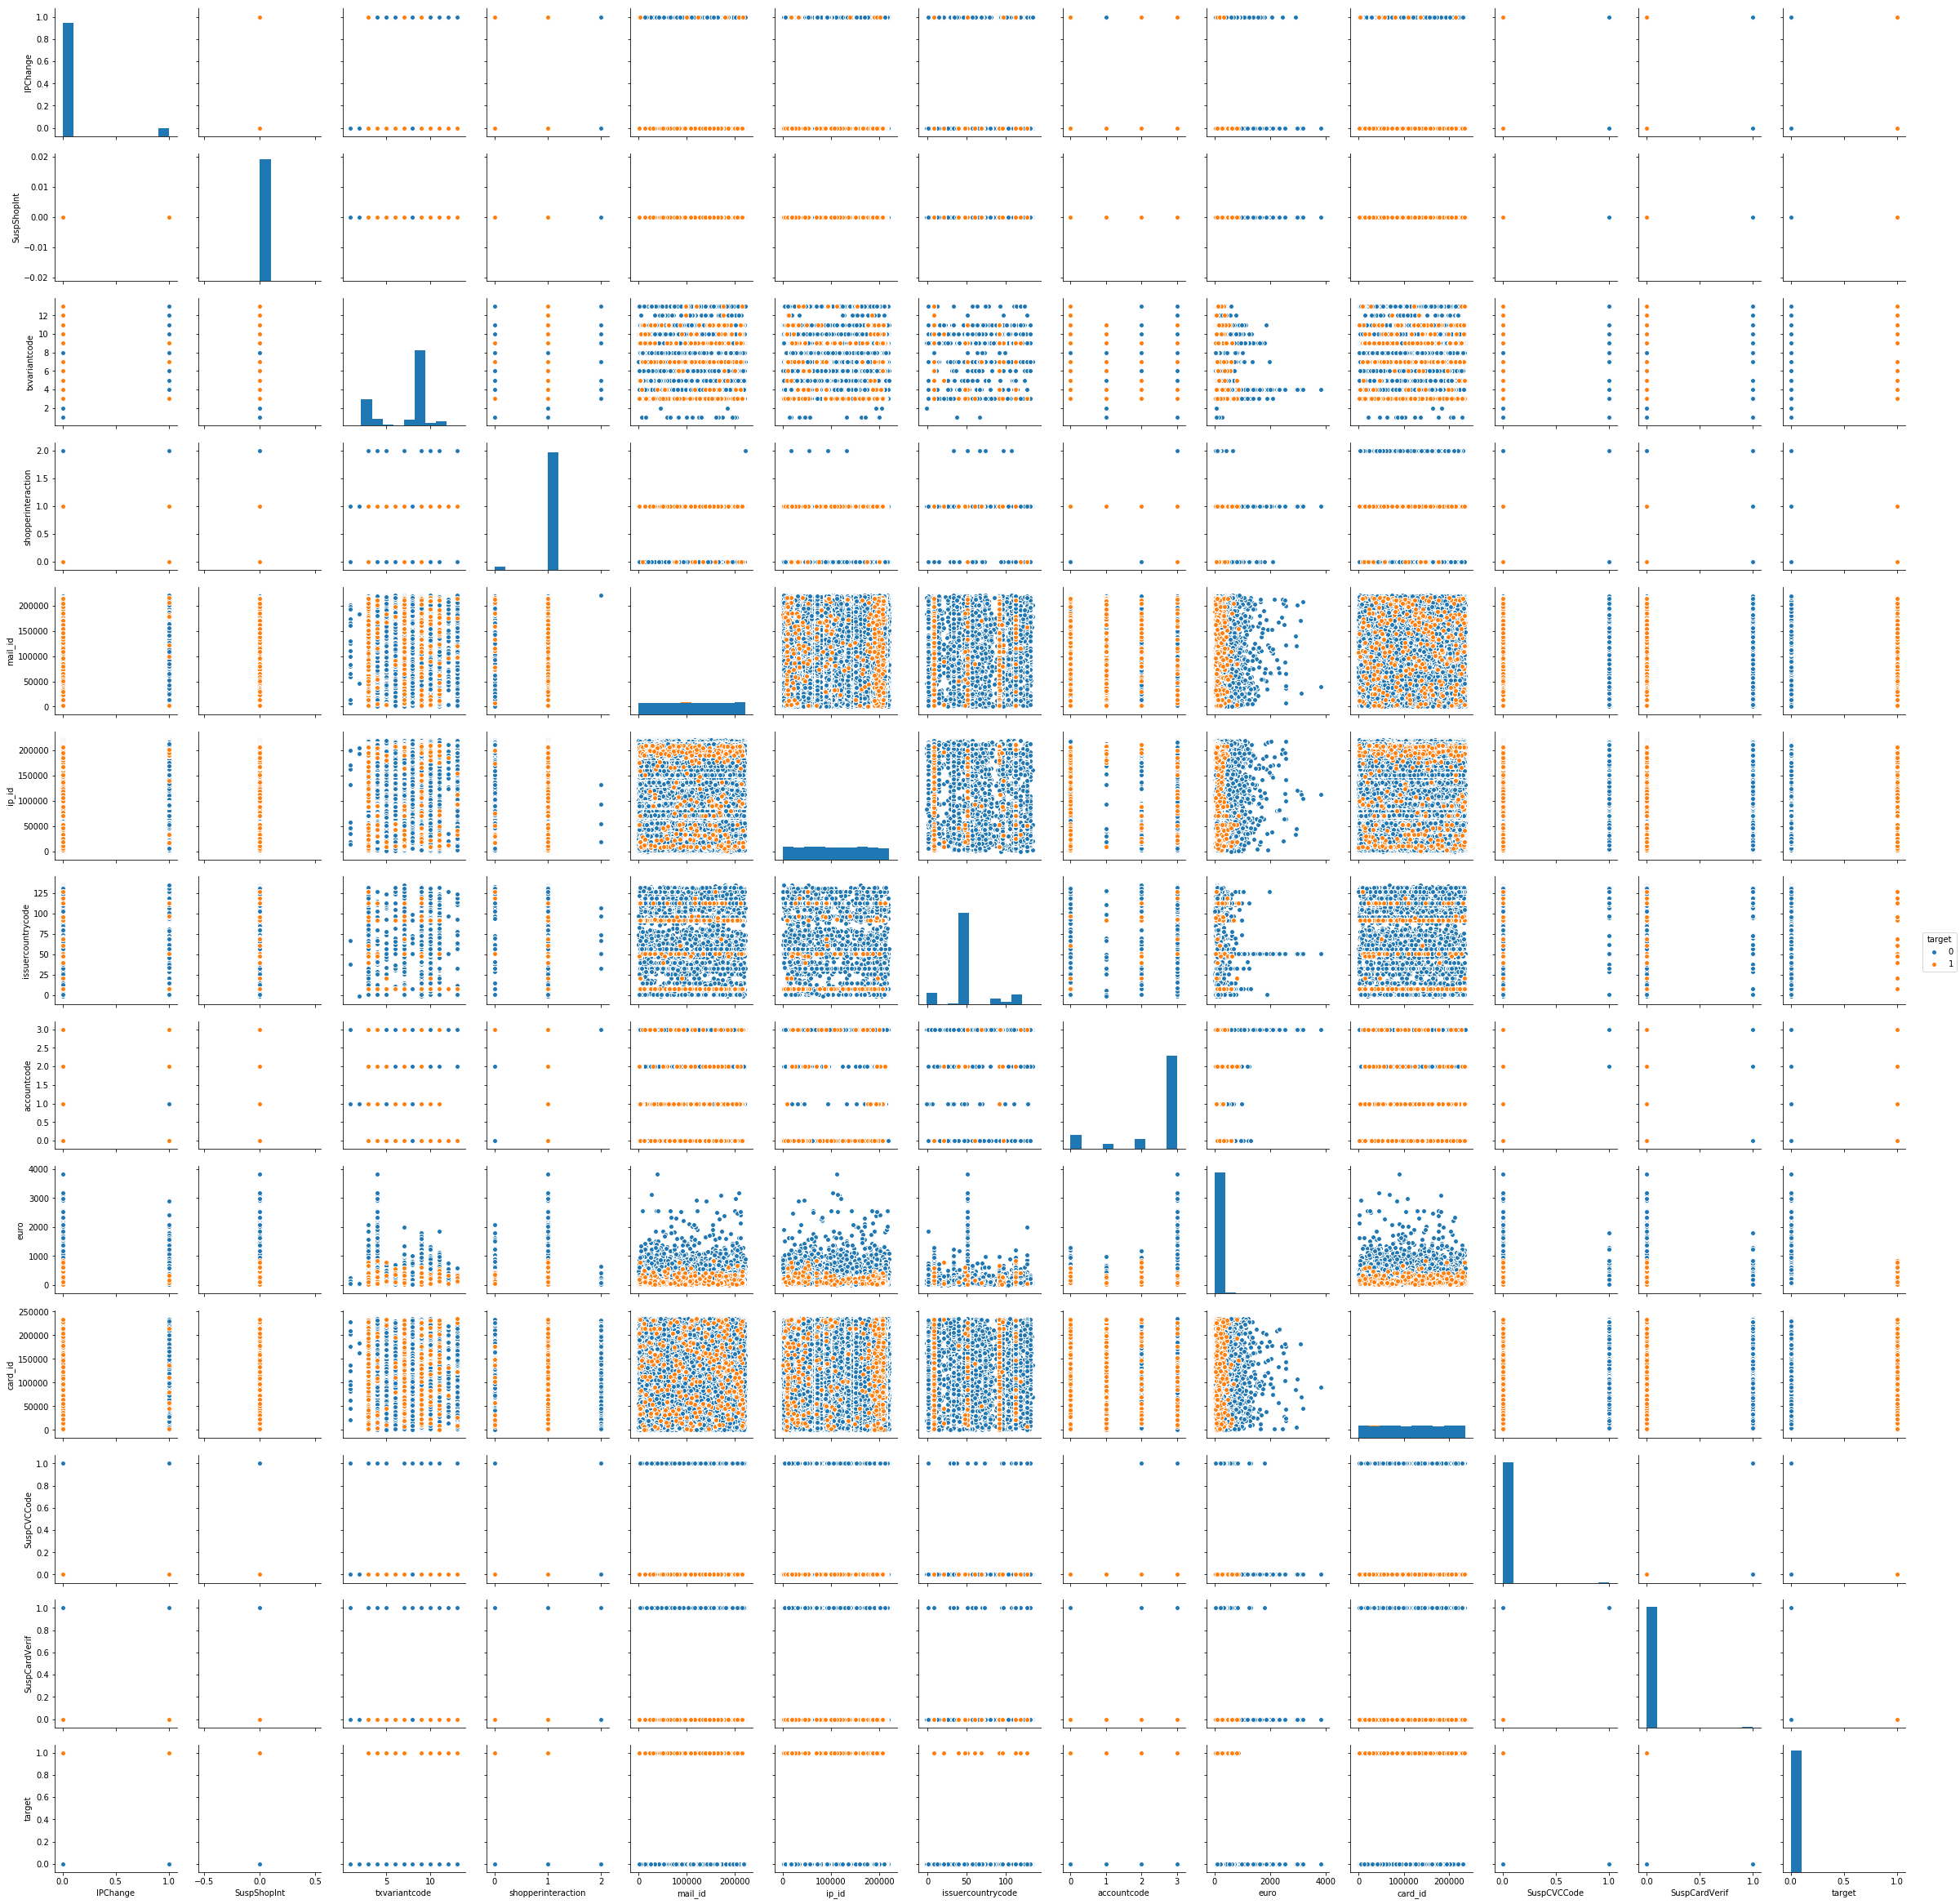

In [23]:
sns.pairplot(analysisTable, hue="target")

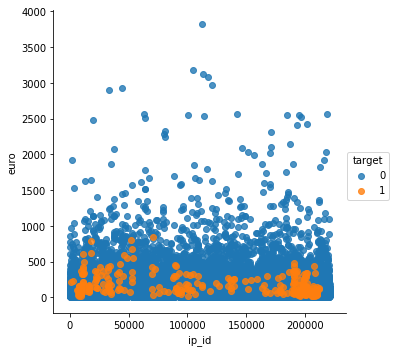

In [24]:
analysisTable = shuffle(analysisTable)
sns.lmplot(x="ip_id", y="euro", hue="target", fit_reg=False, data=analysisTable)

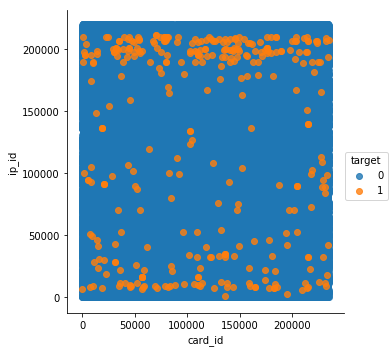

In [25]:
analysisTable = shuffle(analysisTable)
sns.lmplot(x="card_id", y="ip_id", hue="target", fit_reg=False, data=analysisTable)

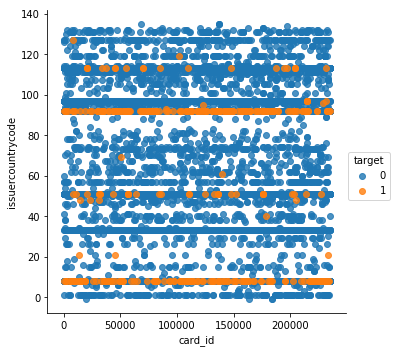

In [26]:
analysisTable = shuffle(analysisTable)
sns.lmplot(x="card_id", y="issuercountrycode", hue="target", fit_reg=False, data=analysisTable)

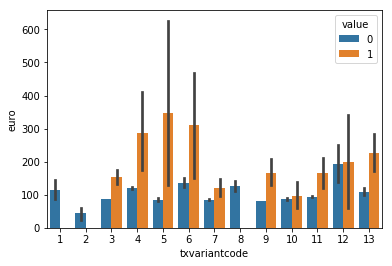

In [27]:
long_df = pd.melt(analysisTable,id_vars = ['euro','txvariantcode'],value_vars =['target'])
my_plot = sns.barplot(x="txvariantcode", y="euro",hue = "value", data=long_df)


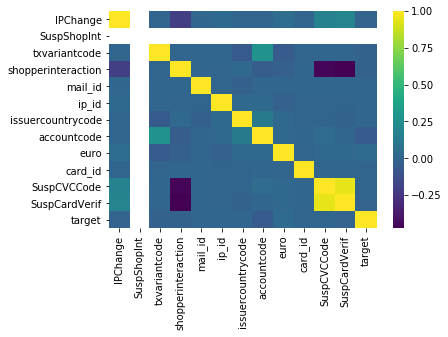

In [28]:
corr_matrix=analysisTable.corr()

sns.heatmap(corr_matrix, cmap='viridis')

In [29]:
# Checkpoint: backup table
analysisTable.to_csv('toAnalyzeTable.csv')

# Get Analysis Table
   

In [104]:
# Checkpoint
#analysisTable = pd.read_csv('toAnalyzeTable.csv')
#analysisTable = analysisTable[analysisTable.columns[1:]]

## Shuffle Data

In [105]:
features = analysisTable[analysisTable.columns[1:-1]]
features = shuffle(features)
target = analysisTable[analysisTable.columns[-1]]
target = shuffle(target)

In [106]:
features

,SuspShopInt,txvariantcode,shopperinteraction,mail_id,ip_id,issuercountrycode,accountcode,euro,card_id,SuspCVCCode,SuspCardVerif
222458,0,3,1,71002,194065,92,1,80.9500,205818,0,0
3706,0,4,1,60208,200383,113,2,74.6900,29938,0,0
93423,0,10,1,70404,162282,70,3,107.4560,6425,0,0
11682,0,10,1,155424,188697,15,3,72.5120,157907,0,0
115149,0,3,1,61293,128985,51,3,189.1200,185349,0,0
232124,0,9,1,3877,98329,51,3,87.0400,74099,0,0
116769,0,9,1,129587,117770,51,3,59.8400,96656,0,0
218757,0,3,1,184857,75238,51,3,80.6400,223652,0,0
13930,0,9,1,20614,124,51,3,81.8560,230179,0,0
171387,0,9,1,1361,13575,51,3,25.0240,71664,0,0


In [107]:
TP, FP, FN, TN = 0, 0, 0, 0
X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=0.2,random_state=43)


In [108]:
analysisTable = shuffle(analysisTable)
def test_Folds(folds,par,smo,cutoff):
   
    # data is an array with our already pre-processed dataset examples
    TN,FP,FN,TP = 0,0,0,0
    kf = KFold(n_splits=folds)
    sum = 0
    precisions = []
    #recalls = []
    base_recs = np.linspace(0, 1, 100)
    
    ###ROC Curves
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0
    
    #CROSS VALIDATION
    for train, test in kf.split(analysisTable):
        train_data = np.array(analysisTable)[train]
        #train_data = pd.DataFrame(train_data)
        test_data = np.array(analysisTable)[test]
        #test_data = pd.DataFrame(test_data)
        y_train = train_data[:,-1]
        x_train = train_data[:,:-1]

        y_test = test_data[:,-1]
        x_test = test_data[:,:-1]
        
        #RANDOM UNDERSAMPLER
        if smo == 0 :
            sampler = RandomUnderSampler(ratio='majority')
        ## SMOTE
        elif smo == 1 :
            sampler= SMOTE(random_state=43)  
        ## Tomek Links
        elif smo == 2 :
            sampler = SMOTETomek()
        
        if par == 'rf':
            Clf = RandomForestClassifier(n_estimators=40, criterion='gini')
        elif par == 'dt':
            Clf = tree.DecisionTreeClassifier()
        elif par == 'lr':
            Clf= LogisticRegression()
        elif par == 'svm':
            Clf = RandomForestClassifier(n_estimators=2, criterion='gini')
            
        #TRAIN CLASSIFIER
        if smo!=3:
            x_train, y_train = sampler.fit_sample(x_train, y_train)
        
        Clf.fit(x_train,y_train)
        
        #TEST CLASSIFIER
        predict_proba = Clf.predict_proba(x_test)
        y_predict = (predict_proba[:,1]>cutoff).astype(int)
        
        #ROC CURVE
        fpr, tpr, thresh = roc_curve(y_test, predict_proba[:,1])
        roc_auc = auc(fpr, tpr)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        #PLOT CURVE

        #plt.plot(fpr, tpr, lw=1, alpha=0.3)

        precision, recall, thresholds2 = precision_recall_curve(y_test, predict_proba[:,1])
        precision = interp(base_recs, list(reversed(recall)), list(reversed(precision)))
        precision[0] = 1
        precisions.append(precision)
        
        
        #plt.subplot(1, 2, 2)
        #plt.plot(recall, precision, label = str(par) + '' + str(folds) + 'folds')
        #plt.xlabel('Recall')
        #plt.ylabel('Precision')
        #plt.title('PR Curve')
       
        fTN,fFP,fFN,fTP = confusion_matrix(y_test, y_predict).ravel()  
        
        TN += fTN
        FP += fFP
        FN += fFN
        TP += fTP
        
        #print ('TP: '+ str(fTP))
        #print ('FP: '+ str(fFP))
        #print ('FN: '+ str(fFN))
        #print ('TN: '+ str(fTN))
        i += 1
    
    
    
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    tprs = np.array(precisions)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)
    

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = np.maximum(mean_tprs - std, 0)#mean_tprs - std

    plt.plot(base_recs, mean_tprs, color='red',lw=2, alpha=.8,linestyle='-')

    plt.fill_between(base_recs, tprs_lower, tprs_upper, color='red', alpha=0.3,label=r'$\pm$ 1 std. dev.')
    plt.show()
    
 
    std_tpr = np.std(tprs, axis=0)
    tprs_upperroc = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lowerroc = np.maximum(mean_tpr - std_tpr, 0)
    plt.plot(mean_fpr, mean_tpr,
         label=par,
         lw=2, alpha=.8)
    plt.fill_between(mean_fpr, tprs_lowerroc, tprs_upperroc, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    print ('CUTOFF: '+ str(cutoff))
    print ('TP: '+ str(TP))
    print ('FP: '+ str(FP))
    print ('FN: '+ str(FN))
    print ('TN: '+ str(TN))
    plt.show()
    return (mean_fpr,mean_tpr,base_recs,mean_tprs)

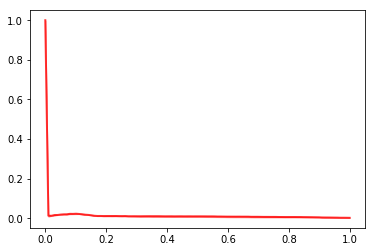

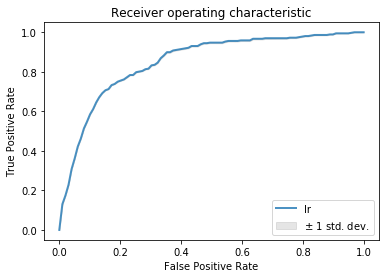

CUTOFF: 0.24
TP: 320
FP: 98887
FN: 25
TN: 137804


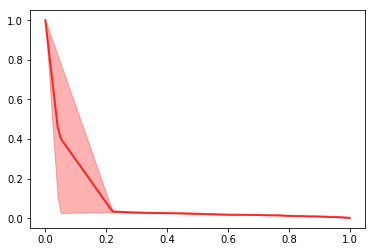

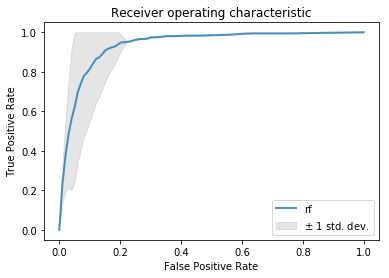

CUTOFF: 0.24
TP: 333
FP: 67592
FN: 12
TN: 169099


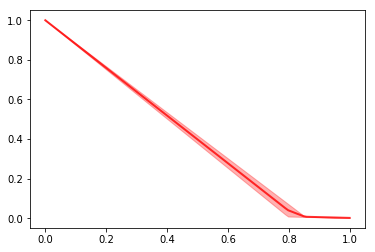

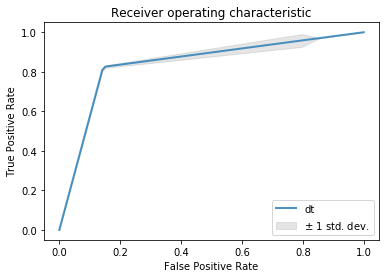

CUTOFF: 0.24
TP: 284
FP: 34108
FN: 61
TN: 202583


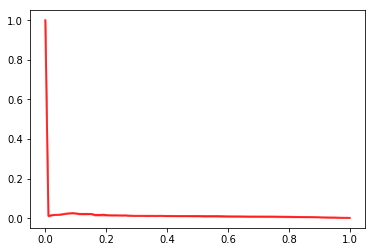

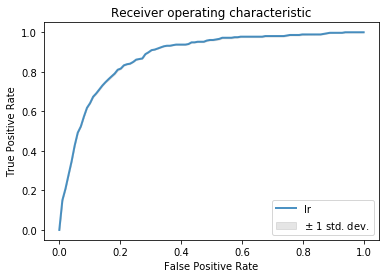

CUTOFF: 0.24
TP: 318
FP: 81564
FN: 27
TN: 155127


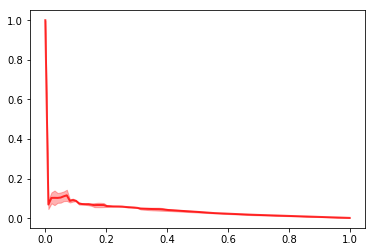

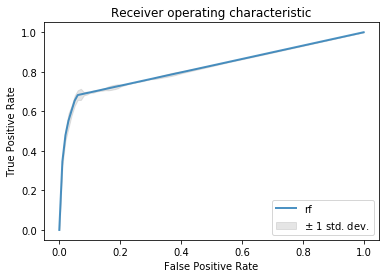

CUTOFF: 0.24
TP: 71
FP: 1151
FN: 274
TN: 235540


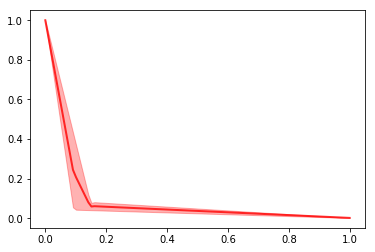

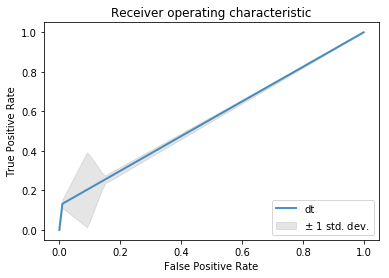

CUTOFF: 0.24
TP: 44
FP: 660
FN: 301
TN: 236031


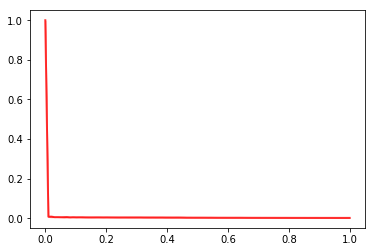

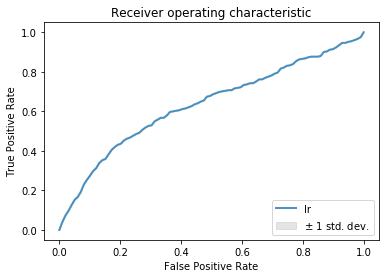

CUTOFF: 0.24
TP: 0
FP: 1
FN: 345
TN: 236690


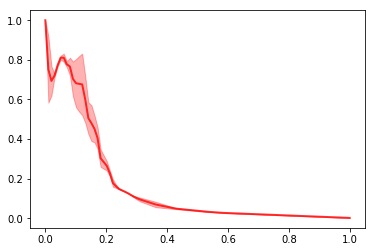

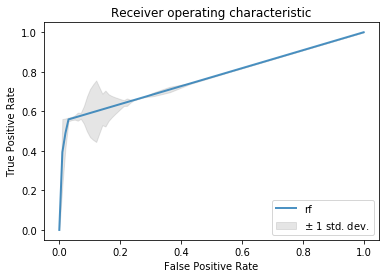

CUTOFF: 0.24
TP: 50
FP: 50
FN: 295
TN: 236641


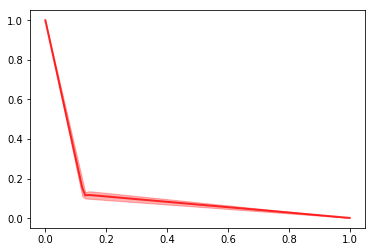

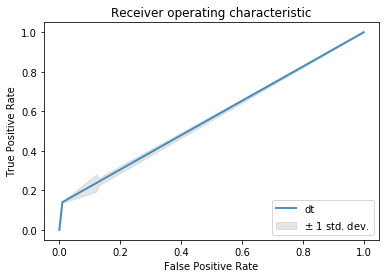

CUTOFF: 0.24
TP: 46
FP: 343
FN: 299
TN: 236348


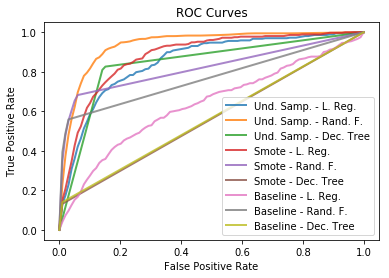

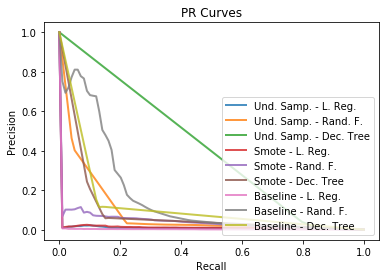

In [114]:
res={}
trans = {0:"Und. Samp.",1:"Smote",3:"Baseline","lr":"L. Reg. ","rf":"Rand. F.","dt":"Dec. Tree"}
for smote in [0,1,3]:
    for clf in ["lr","rf","dt"]:
        res[str(trans[smote]) +" - "+trans[clf]]=test_Folds(2,clf,smote,0.24)

for roc in res:
    plt.plot(res[roc][0], res[roc][1],
         label=roc,
         lw=2, alpha=.8)
    

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

for roc in res:
    plt.plot(res[roc][2], res[roc][3],
         label=roc,
         lw=2, alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curves')
plt.legend(loc="lower right")
plt.show()

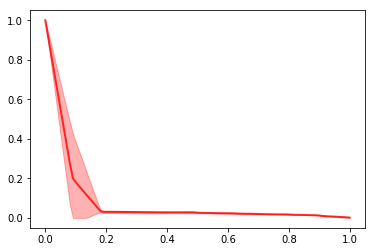

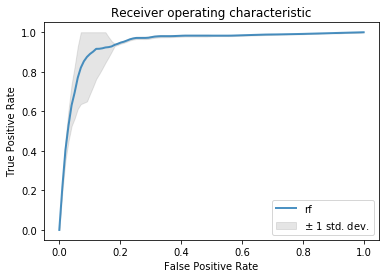

CUTOFF: 0.3
TP: 329
FP: 50788
FN: 16
TN: 185903


(array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
        0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
        0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
        0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
        0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
        0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
        0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
        0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
        0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
        0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
        0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
        0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
        0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
        0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
        0.70707071, 0.71717172, 0.72727273, 0.73

In [115]:
test_Folds(3,'rf',0,0.3)

In [ ]:
test_Folds(10,'rf',1,0.255)

In [ ]:
test_Folds(10,'rf',1,0.245)

In [ ]:
test_Folds(10,'rf',0,0.98)

In [ ]:
test_Folds(10,'rf',1,0.25)

In [ ]:
test_Folds(10,'rf',1,0.249)

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: Matplo

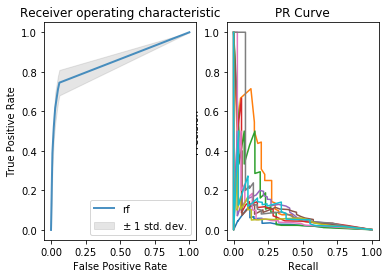

CUTOFF: 0.24
TP: 95
FP: 1075
FN: 250
TN: 235616


/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: Matplo

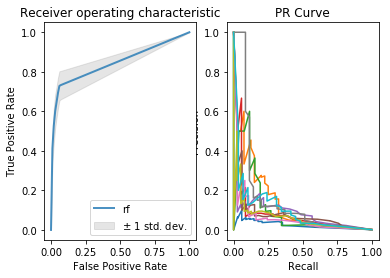

CUTOFF: 0.241
TP: 92
FP: 1065
FN: 253
TN: 235626


/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: Matplo

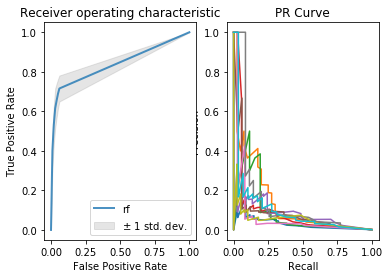

CUTOFF: 0.242
TP: 86
FP: 1100
FN: 259
TN: 235591


/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: Matplo

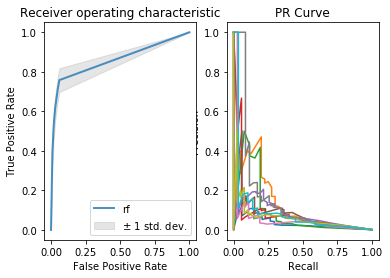

CUTOFF: 0.243
TP: 99
FP: 1086
FN: 246
TN: 235605


/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: Matplo

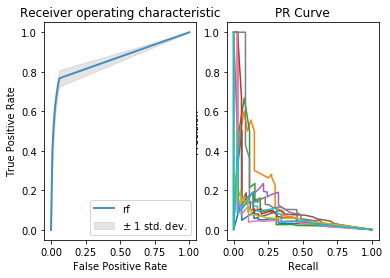

CUTOFF: 0.244
TP: 98
FP: 1091
FN: 247
TN: 235600


/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: Matplo

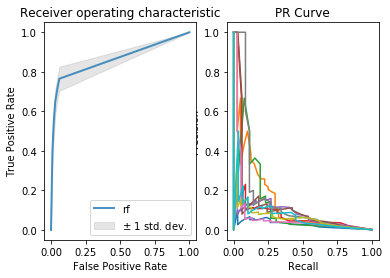

CUTOFF: 0.245
TP: 101
FP: 1061
FN: 244
TN: 235630


/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: Matplo

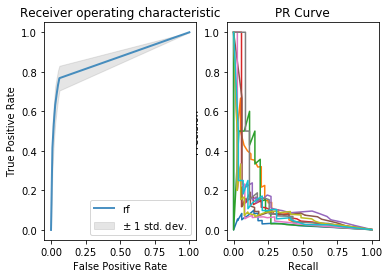

CUTOFF: 0.246
TP: 93
FP: 1075
FN: 252
TN: 235616


/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: Matplo

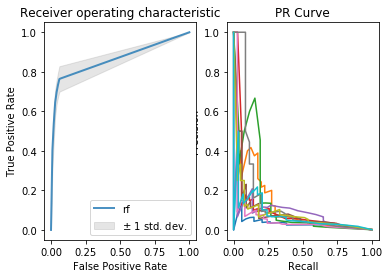

CUTOFF: 0.247
TP: 92
FP: 1070
FN: 253
TN: 235621


In [49]:
# best performance
for cutoff in [0.24,0.241,0.242,0.243,0.244,0.245,0.246,0.247]:
    test_Folds(10,'rf',1,cutoff)

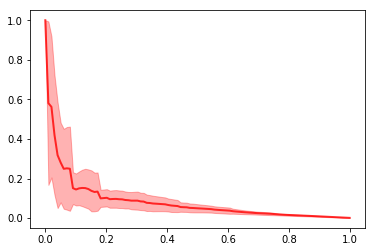

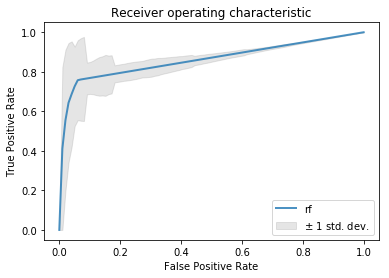

CUTOFF: 0.24
TP: 94
FP: 1033
FN: 251
TN: 235658


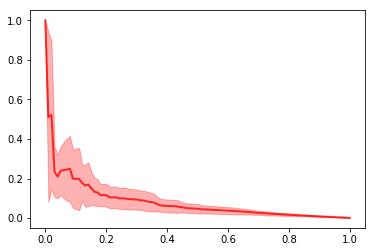

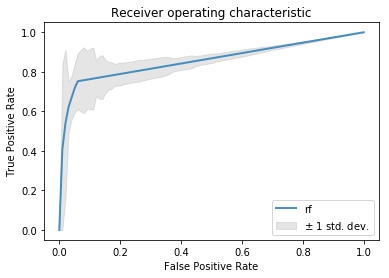

CUTOFF: 0.241
TP: 97
FP: 1083
FN: 248
TN: 235608


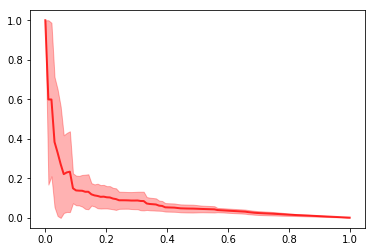

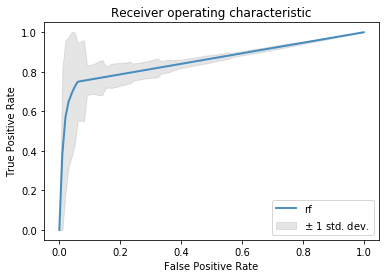

CUTOFF: 0.242
TP: 89
FP: 1093
FN: 256
TN: 235598


In [ ]:
for cutoff in [0.24,0.241,0.242,0.243,0.244,0.245,0.246,0.247]:
    test_Folds(10,'rf',2,cutoff)

In [ ]:
test_Folds(10,'rf',2,0.241)

In [ ]:
test_Folds(10,'lr',2,0.6)

In [ ]:
test_Folds(10,'lr',1,0.6)